# 일원분산분석 NOVA (분산분석)

세 개 이상의 집단 간 평균의 차이를 검증하기 위해 사용된다.

분산분석에는 일원분산분석(One-Way ANOVA)과 이원분산분석(Two-Way ANOVA)이 있다.

분산분석의 결과가 통계적으로 유의하다는 결론을 얻었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지를 검증하기 위해 사후검정을 수행할 수 있다.

## #01. 준비작업

### [1] 패키지 참조

`pingouin` 패키지의 설치가 필요하다

In [28]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from matplotlib import pyplot as plt
from pandas import read_excel, melt, DataFrame
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### [2] 그래프 초기화

In [13]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.unicode_minus"] = False

### [3] 데이터 가져오기

동일한 제품을 판매하고 있는 서로 다른 두 지역의 매장의 100일간 일별 매출액을 기록한 가상의 데이터이다.

이 데이터를 사용하여 두 매장의 평균을 비교하라.

In [14]:
origin = read_excel("https://data.hossam.kr/mldata/store.xlsx")
origin

,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58
...,...,...
95,53,69
96,52,51
97,52,65
98,49,59


## #02. 데이터 분포 확인

### [1] 데이터 재배치

In [15]:
df = melt(origin, var_name="store", value_name="sales")
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


### [2] 커널밀도함수 그래프

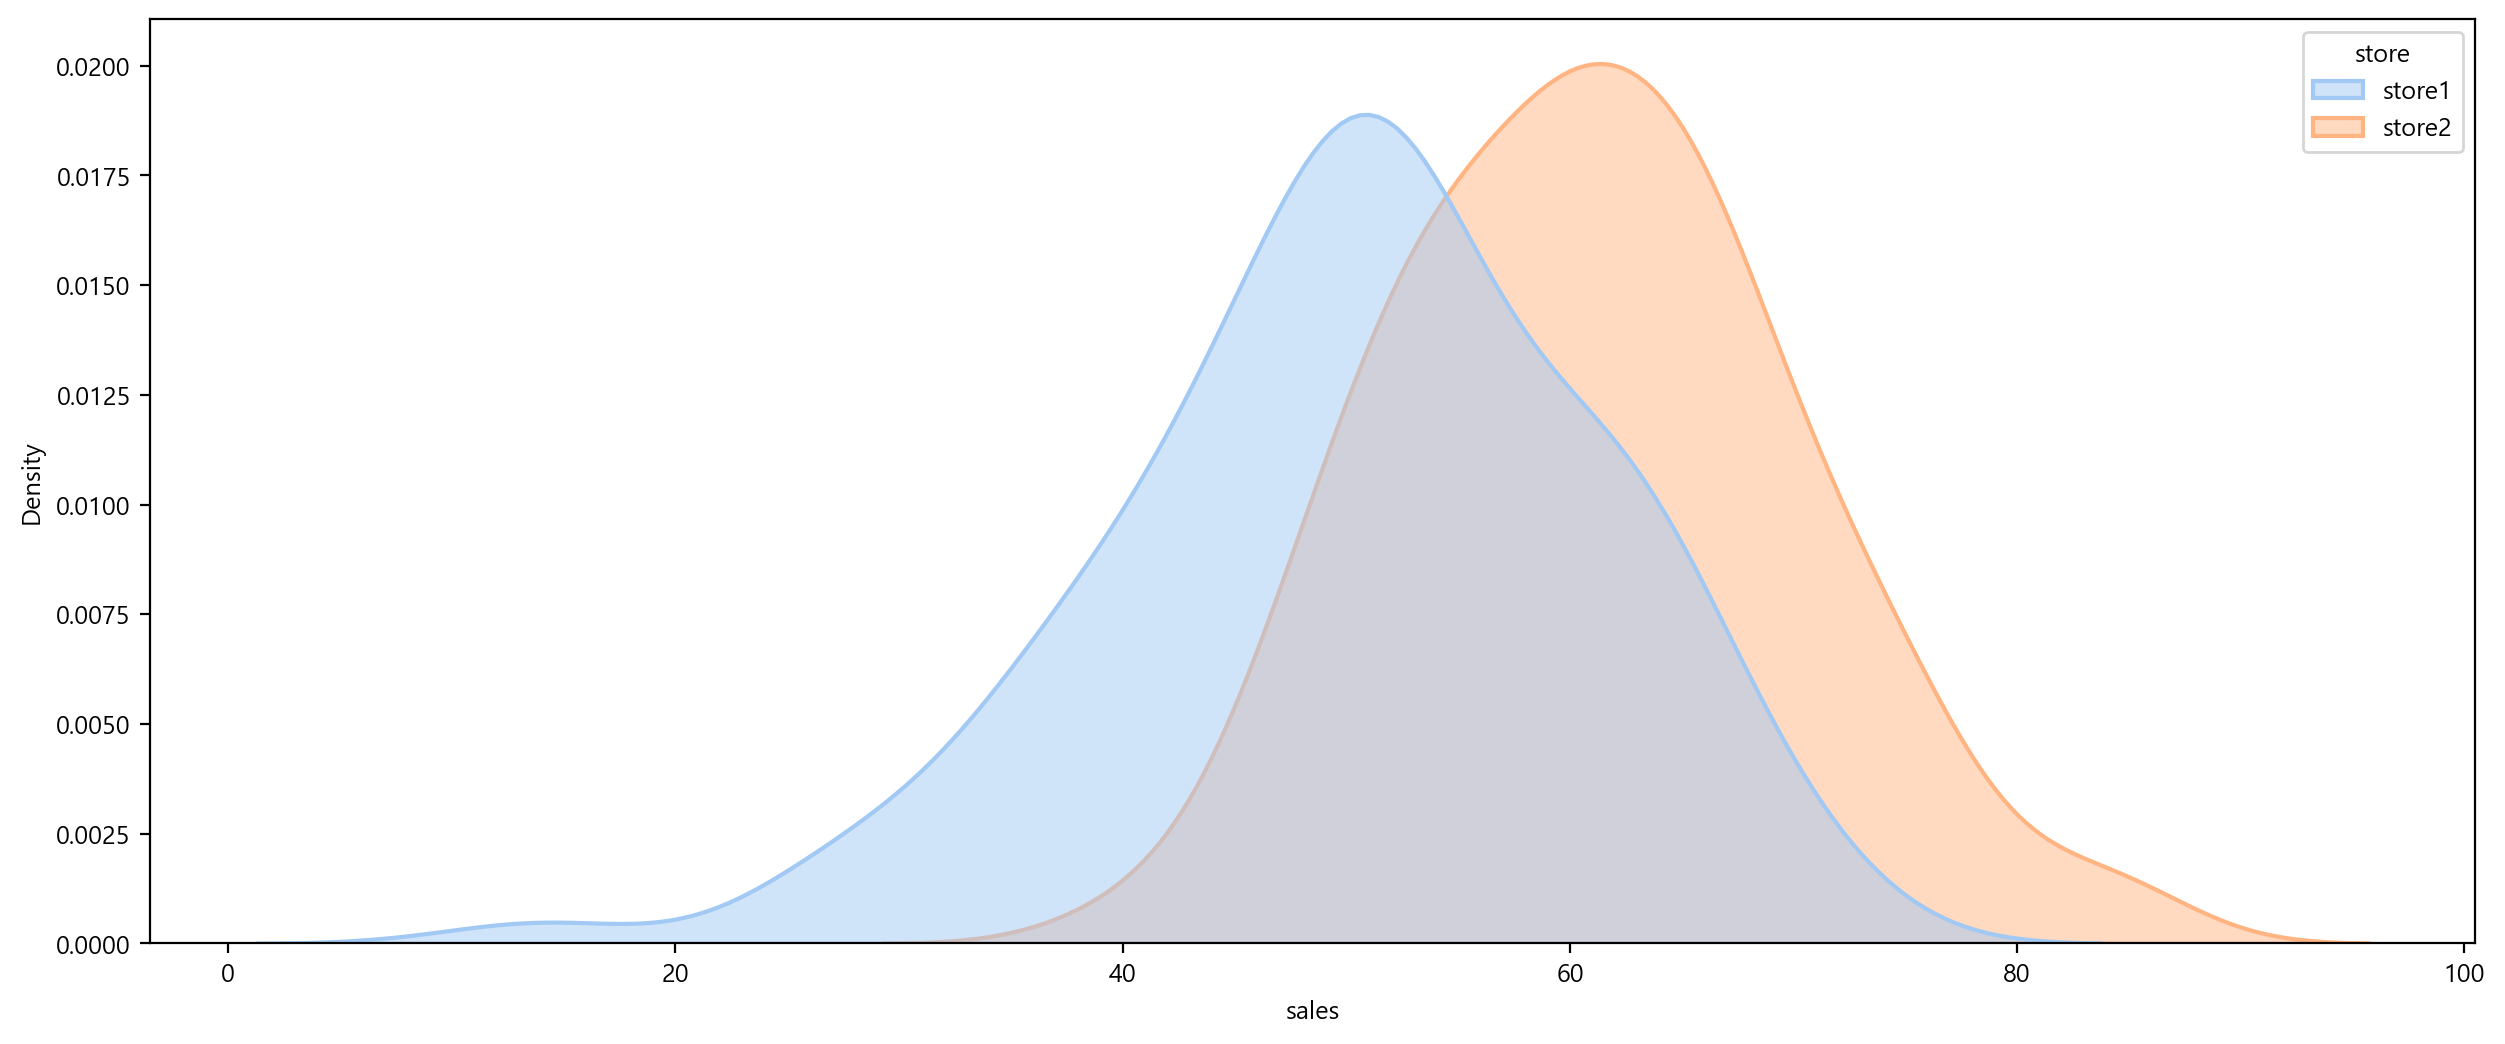

In [16]:
plt.figure()
sb.kdeplot(data=df, x="sales", hue="store", 
           palette='pastel', fill=True, alpha=.5, linewidth=1.5)
plt.show()
plt.close()

## #03. 분산분석의 가정 확인

### [1] 정규성 검정

In [17]:
data = df.copy()
xname = 'store'
yname = 'sales'

u1 = data[xname].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    filtered_data = data[data[xname] == i][yname]
    equal_var_fields.append(filtered_data)
    s, p = normaltest(filtered_data)

    normalize = p > 0.05
    report.append({
        "field": i,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
store1,5.651229,0.059272,True
store2,1.173772,0.556056,True
Bartlett,2.843923,0.091720,True


> 가즈아~!!

## #04. 일원분산분석 수행

일원분산분석에는 scipy 패키지의 `f_oneway()`함수, statsmodels 패키지의 `anova_lm()`함수, pingouin 패키지의 `anova()` 함수를 사용하는 방법이 있다.

어떤 방법을 사용하더라도 결과는 동일하다., 

### [1] `scipy` 패키지 사용

분산분석을 수행할 변수를 파라미터로 전달한다.

등분산성을 만족하지 않을 경우 `equal_var=False` 파라미터를 함께 설정한다.

In [18]:
s, p = f_oneway(origin['store1'], origin['store2'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

`p-value`가 0.05보다 작으므로 귀무가설을 기각하고 대립가설을 채택한다.

즉, 두 가게의 일별 매출 평균은 다르다.

### [2] `statsmodels` 패키지 사용

#### (1) 데이터 전처리

명목형 변수와 연속형 변수로 구성된 형태로 데이터를 재배치 해야 한다.

In [19]:
df = melt(origin, var_name='store', value_name='sales')
df

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37
...,...,...
195,store2,69
196,store2,51
197,store2,65
198,store2,59


#### (2) 분산분석

데이터가 등분산성을 만족하지 않을 경우 `anova_lm()` 함수에 `robust='hc3'` 파라미터를 사용하여 Huber-White 추정치를 사용한다.

In [20]:
lm = ols('sales ~ C(store)', data=df).fit()
anova_result = anova_lm(lm)
print(anova_result)

             df     sum_sq      mean_sq          F        PR(>F)
C(store)    1.0   5735.205  5735.205000  58.717529  7.945482e-13
Residual  198.0  19339.550    97.674495        NaN           NaN


In [21]:
s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

### [3] pingouin 패키지 사용

#### (1) 등분산성을 충족하는 경우

In [22]:
anova(data=df, dv='sales', between='store')

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,198,58.717529,7.945482e-13,0.228724


#### (2) 등분산성을 충족하지 않는 경우

데이터가 등분산성을 만족하지 않을 경우 `anova()` 함수 대신 같은 패키지에 있는 `welch_anova()` 함수를 사용한다.

파라미터 설정 동일함 (권장)

> 이 예제는 등분산성을 충족하는 데이터 이지만 코드 전개를 제시하기 위하여 사용해 봄

In [26]:
welch_anova(data=df, dv='sales', between='store')

,Source,ddof1,ddof2,F,p-unc,np2
0,store,1,192.521085,58.717529,8.694831e-13,0.228724


## #05. 사후검정 (post hoc)

ANOVA의 결과를 통해 두 집단의 분산에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

### [1] 사후검정의 가정

| 가설 | 내용 |
|---|---|
| 귀무가설 | 집단간 분산이 차이가 없다(같다) |
| 대립가설 | 집단간 분산이 차이가 있다(다르다) |

### [2] 사후검정의 종류

| 종류 | 사용 |
|---|---|
| 투키의 HSD | 등분산이고 샘플수가 동일한 경우 |
| 본페로니 교정, 피셔의 LSD, 셰페의 방법 | 등분산이고 샘플수가 다른 경우 |
| Games Howell | 등분산이 아닌 경우 |

`피셔의 LSD`와 `셰페의 방법`은 검정력이 다소 약하기 때문에 잘 사용되지 않는다.

### [3] 투키의 HSD

`Tuckey's Honestly Significant Difference` = "진정으로 유의미한 차이"

`OO`(명목형)에 따른 `ㅁㅁ`(연속형)의 차이라는 의미로 접근한다.

#### (1) statsmodels 패키지를 사용하는 경우

연속형 변수와 각 데이터를 구별할 수 있는 명목형 변수 순으로 파라미터를 설정한다.

In [23]:
tukey = pairwise_tukeyhsd(df['sales'], df['store'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
store1,store2,10.71,0.0,7.9538,13.4662,True


> 사후 분석 결과 `store`에 따른 `sales`의 차이는 통계적으로 유의미하였다.($P<0.05$)
>
> store1과 store2의 평균은 `10.71`정도의 차이가 있으며 `95%`신뢰구간은 `7.9538~13.4462`인 것으로 나타났다.

#### (2) pingouin 패키지를 사용하는 경우

In [27]:
pairwise_tukey(data=df, dv='sales', between='store')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,8.714141e-13,-1.079565


### [4] 본페로니 교정

원래는 집단간 샘플 수가 동일하지 않을 경우 수행되는 방법이지만 여기서는 소스코드 확인을 위해 진행한다.

다소 엄격한 기각역을 설정하고 있기 때문에 제2종 오류 발생 위험이 있다.

#### (1) statsmodels 패키지를 사용하는 경우

검정 결과에서 `pval_corr`값이 `0.05`보다 작은 항목간의 비교에서 통계적으로 유의미한 차이가 있다고 해석한다.

In [29]:
comp = MultiComparison(df['sales'], df['store'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
store1,store2,-7.6627,0.0,0.0,True


> 본페로니 교정 결과 `store1`과 `store2`의 평균은 통계적으로 유의미한 차이가 있다($P \leq 0.05$)

#### (2) pingouin 패키지를 사용하는 경우

In [30]:
pairwise_tests(data=df, dv='sales', between='store', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,store,store1,store2,False,True,-7.662736,198.0,two-sided,7.945482e-13,8.14e+09,-1.079565


### [5] Games-Howell 검정

`Games-Howell` 검정은 다수의 그룹 간의 평균 차이를 비교하는 통계적 방법 중 하나로, 등분산성 가정이 만족되지 않을 때 사용된다.

이 예제에 적합한 방법은 아니지만 소스코드의 제시를 목적으로 사용한다.

`scipy` 라이브러리에는 `Games-Howell` 검정을 직접 지원하는 함수는 없지만, `pingouin` 라이브러리를 사용하여 `Games-Howell` 검정을 수행할 수 있다.

In [25]:
result = pairwise_gameshowell(df, dv='sales', between='store')
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565
